In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scikitplot as sp

from numpy.typing import ArrayLike
from typing import Callable
from pathlib import Path

from scipy.sparse import spmatrix
from scipy.stats import loguniform, uniform

# ML lybraries
import xgboost as xgb
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate, RandomizedSearchCV
from sklearn.metrics import make_scorer
from sklearn.base import BaseEstimator
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import SGDClassifier
from imblearn.over_sampling import SMOTE
from insurance_classifier.dataset import DataPreprocessor

2026-02-11 13:26:41.778 | INFO     | insurance_classifier.config:<module>:11 - PROJ_ROOT path is: /home/iury_unix/ml_projects/h_insurance_cs


# 0.0 Loading data

In [2]:
train = pd.read_csv('../data/processed/train.csv')

X = train.drop(['response'], axis=1)
y = train['response'].copy()


In [3]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

## 0.1 Helper Functions

In [41]:
def check_imbalance(df: pd.DataFrame)-> pd.DataFrame: 
    total = df.shape[0]
    no_count = df['response'].value_counts().iloc[0]
    yes_count = df['response'].value_counts().iloc[1]

    def highlight(val):
        return 'background-color: red; color: white; font-weight: bold;' if val < 20 else ''

    no_percentage = (no_count/total) * 100
    yes_percentage = 100 - no_percentage

    df_dist = pd.DataFrame({'no_count': no_count,
                            'yes_count': yes_count,
                            'no_percentage': no_percentage,
                            'yes_percentage': yes_percentage
                }, index=[0]).style.map(highlight, subset=['no_percentage','yes_percentage'])

    return df_dist 

def precision_at_k(y_true, y_proba, *, k):
    if y_proba.ndim > 1:
        pos_proba = y_proba[:, 1]
    else: 
        pos_proba = y_proba
    idx = np.argsort(pos_proba)[::-1][:k]   
    
    return np.mean(y_true.iloc[idx])

def recall_at_k(y_true, y_proba, *, k):
    if y_proba.ndim > 1:
        pos_proba = y_proba[:, 1]
    else: 
        pos_proba = y_proba
    idx = np.argsort(pos_proba)[::-1][:k]  

    return np.sum(y_true.iloc[idx]) / np.sum(y_true) if np.sum(y_true) > 0 else 0

def f_score_at_k(y_true, y_proba, *, k):   
    if y_proba.ndim > 1:
        pos_proba = y_proba[:, 1]
    else: 
        pos_proba = y_proba
    idx = np.argsort(pos_proba)[::-1][:k] 

    precision = np.mean(y_true.iloc[idx])
    recall = np.sum(y_true.iloc[idx]) / np.sum(y_true)

    return  2 * ((precision * recall)/(precision + recall)) if (precision + recall) > 0 else 0


def cross_validation_at_k(model:BaseEstimator, X:pd.DataFrame, y:ArrayLike|None, return_dict:bool=False, verbose:int=0, *, cv:int=5, k:int)-> pd.DataFrame | np.ndarray: 
    """
    Perform cross-validation using @k metrics (precision@k, recall@k, and F1-score@k) as the scoring method.

    Parameters
    ----------
    model : instance of estimator, needs to inherit from sklearn's BaseEstimator.
        Estimator object to be evaluated.

    X : dataframe of shape (n_samples, n_features). 
        Training data.

    y : array-like of shape (n_samples,)
        Target values.

    return_dict : boolean, default=False
        If True, returns the raw cross-validation results dictionary.

    verbose : int, default=0
        Verbosity level for cross-validation process.

    cv : int, default=5
        Number of cross-validation folds. If use int, specify number of folds in a Stratified KFold. 

    k : int
        The top k values for metrics @k.

    Returns
    ---------
    pd.Dataframe | dict : pandas dataframe or dict
        Dataframe or dict with precision@k, recall@k, f1-score@k, calculated for each cv fold.
    
    See Also
    --------
    sklearn.model_selection.cross_validate : Perform cross-validation.
    make_scorer : Convert a metric function into a scorer object.
    """
    precision_at_k_scorer = make_scorer(precision_at_k, response_method='predict_proba', k=k)
    recall_at_k_scorer = make_scorer(recall_at_k, response_method='predict_proba', k=k)
    f1_at_k_scorer = make_scorer(f_score_at_k, response_method='predict_proba', k=k)   

    model_results = cross_validate(model, X, y, cv=cv, scoring={'recall': recall_at_k_scorer, 'precision': precision_at_k_scorer, 'f1': f1_at_k_scorer}, verbose=verbose)

    if return_dict:
        return model_results

    at_k_metrics = pd.DataFrame(model_results)
    at_k_metrics.rename(columns={'test_recall': 'recall@k', 'test_precision': 'precision@k', 'fit_time': 'fit_time', 'test_f1': 'f1-score@k'}, inplace=True)
    at_k_metrics.drop(columns='score_time', inplace=True)
    at_k_metrics = at_k_metrics[['precision@k', 'recall@k', 'f1-score@k', 'fit_time']]
    at_k_metrics = at_k_metrics.sort_values(by='precision@k', ascending=False)

    
    return at_k_metrics

def cross_val_summary(results_dict:dict) -> pd.DataFrame:
    """
    Summarizes the results of cross-validation for multiple models.

    Parameters
    ----------
    results_dict : dict of shape {str: pd.DataFrame}
        A dictionary where keys are model names and values are dataframes containing cross-validation results.
    
    Returns
    -------
    pd.DataFrame
        A dataframe summarizing the mean precision@k, recall@k, f1-score@ and fit time for each model.
    """ 
    rows = []  

    for name, r in results_dict.items():
        rows.append({
            'Model Name': name,
            'precision@k_mean': np.round(np.mean(r['precision@k']), 3),
            'recall@k_mean': np.round(np.mean(r['recall@k']), 3),
            'f1-score@k_mean': np.round(np.mean(r['f1-score@k']), 3),
            'fit_time_mean': np.round(np.mean(r['fit_time']), 3),
        })

    df = pd.DataFrame(rows).sort_values(by='precision@k_mean', ascending=False)

    return df


---

---

# 1.0 Linear Models (baseline)

### 1.1 SGD Classifier with Linear SVM (Loss function = hinge)

In [17]:
# Model initialization
sgd_lin = SGDClassifier(loss='hinge')

# Predict probabilities
clf = CalibratedClassifierCV(sgd_lin)

# Train
clf.fit(X_train, y_train)

# Predict
y_hat_lin = clf.predict_proba(X_test)


### 1.2 SGD Classifier with Logistic Regression (Loss function = log-loss)

In [68]:
# Model initialization
sgd_log = SGDClassifier(loss='log_loss')

# Train
sgd_log.fit(X_train, y_train)

# Predict
y_hat_log = sgd_log.predict_proba(X_test)

<b>Baseline Performance</b>:

In [ ]:
# Linear SVM
precision_lin = precision_at_k(y_true=y_test, y_proba=y_hat_lin, k=20000)
recall_lin = recall_at_k(y_true=y_test, y_proba=y_hat_lin, k=20000)

# Log-loss
precision_log = precision_at_k(y_true=y_test, y_proba=y_hat_log, k=20000)
recall_log = recall_at_k(y_true=y_test, y_proba=y_hat_log, k=20000)

# Dataframe
results = pd.DataFrame({'Model': ['Linear SVM', 'logistic regression'],
                        '@k': [20000, 20000],
                        'Precision@k': [precision_lin, precision_log],
                        'Recall@k': [recall_lin, recall_log]})
results

,Model,@k,Precision@k,Recall@k
0,Linear SVM,20000,0.30280,0.652586
1,logistic regression,20000,0.31235,0.673168


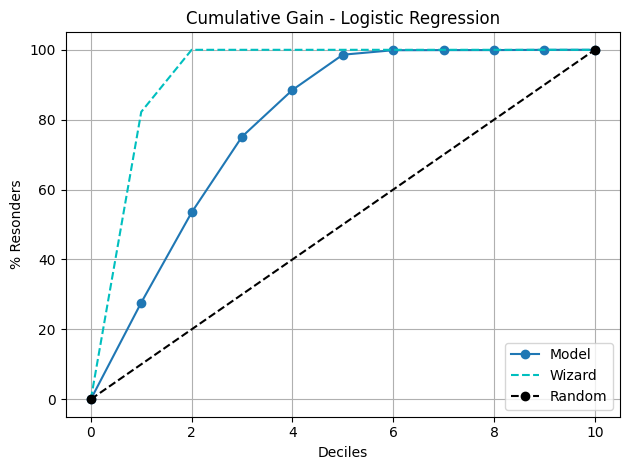

In [ ]:
sp.kds.plot_cumulative_gain(y_test, y_hat_log[:,1], title='Cumulative Gain - Logistic Regression');

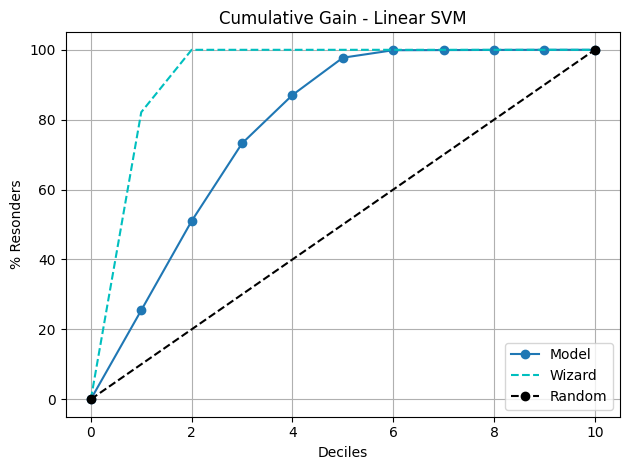

In [ ]:
sp.kds.plot_cumulative_gain(y_test, y_hat_lin[:,1], title='Cumulative Gain - Linear SVM');

# 2.0 Non-linear Models (baseline)

## 2.1. K Neighbors Classifier

In [ ]:
# model initialization
knn = KNeighborsClassifier(n_neighbors=5)

# Train
knn.fit(X, y)

# Predict
knn_proba = knn.predict_proba(X_test)

<b>Baseline Performance</b>:

In [ ]:
# KNN
precision_knn = precision_at_k(y_true=y, y_proba=knn_proba, k=20000)
recall_knn = recall_at_k(y_true=y, y_proba=knn_proba, k=20000)

# Dataframe
results_knn = pd.DataFrame({'Model': ['KNN'],
                        '@k': 20000,
                        'Precision@k': precision_knn,
                        'Recall@k': recall_knn})
results_knn

,Model,@k,Precision@k,Recall@k
0,KNN,20000,0.28305,0.610745


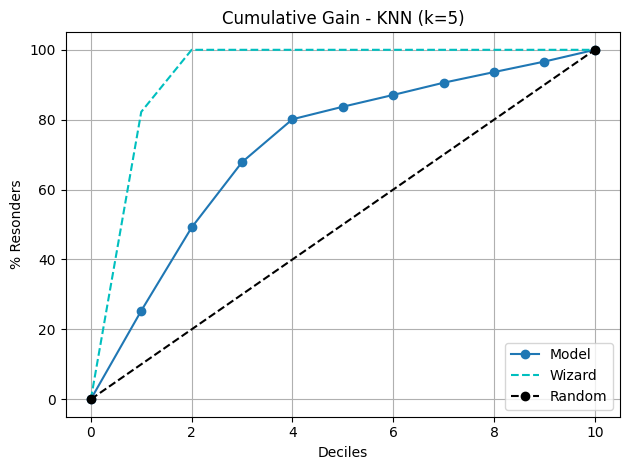

In [ ]:
sp.kds.plot_cumulative_gain(y_test, knn_proba[:,1], title='Cumulative Gain - KNN (k=5)');

## 2.3 XGB Classifier

In [7]:
# Model initialization
xgb_class = xgb.XGBClassifier(n_estimators=100, n_jobs=-1)

# Fit
xgb_class.fit(X_train, y_train)

# Predict
y_hat_xgb = xgb_class.predict_proba(X_test)

In [8]:
precision_xgb = precision_at_k(y_true=y, y_proba=y_hat_xgb, k=20000)
recall_xgb = recall_at_k(y_true=y, y_proba=y_hat_xgb, k=20000)

# Dataframe
results_xgb = pd.DataFrame({'Model': ['XGB'],
                        '@k': 20000,
                        'Precision@k': precision_xgb,
                        'Recall@k': recall_xgb})
results_xgb

,Model,@k,Precision@k,Recall@k
0,XGB,20000,0.12215,0.052301


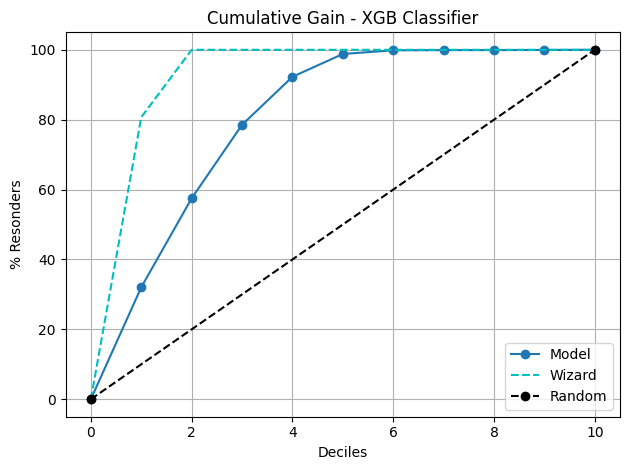

In [14]:
sp.kds.plot_cumulative_gain(y_test, y_hat_xgb[:,1], title='Cumulative Gain - XGB Classifier');

## 2.4 Extra Trees Classifier

In [9]:
# Model initialization
ex_trees = ExtraTreesClassifier(n_jobs=-1)

# Fit
ex_trees.fit(X_train, y_train)

# Predict
y_hat_extrees = ex_trees.predict_proba(X_test)

<b>Baseline Performance</b>:

In [10]:
precision_extrees = precision_at_k(y_true=y, y_proba=y_hat_extrees, k=20000)
recall_extrees = recall_at_k(y_true=y, y_proba=y_hat_extrees, k=20000)

# Dataframe
results_extrees = pd.DataFrame({'Model': ['ExtraTrees'],
                        '@k': 20000,
                        'Precision@k': precision_extrees,
                        'Recall@k': recall_extrees})
results_extrees

,Model,@k,Precision@k,Recall@k
0,ExtraTrees,20000,0.1221,0.05228


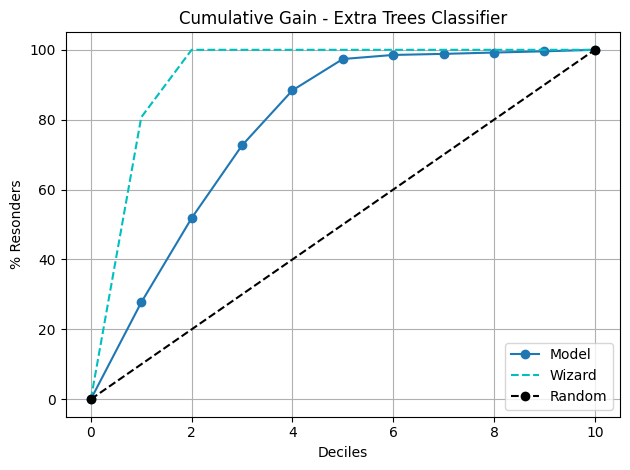

In [15]:
sp.kds.plot_cumulative_gain(y_test, y_hat_extrees[:,1], title='Cumulative Gain - Extra Trees Classifier');

---

---

# 3.0 Cross validation

## 3.1 SGD Classifier: Linear SVM  

In [5]:
# Model definition
sgd_lin = SGDClassifier(loss='hinge')

# Converting predictions into probabilities
sgd_lin_cal = CalibratedClassifierCV(sgd_lin)

In [21]:
# Cross validated performance
sgd_lin_results = cross_validation_at_k(sgd_lin_cal, X_train, y_train, cv=5, k=20000)
sgd_lin_results

,precision@k,recall@k,f1-score@k,fit_time
4,0.29300,0.786261,0.426911,0.856201
0,0.29240,0.784650,0.426037,2.527012
3,0.29190,0.783414,0.425324,2.548066
2,0.29055,0.779791,0.423357,2.447399
1,0.27740,0.744398,0.404182,2.321485


## 3.2 SGD Classifier: Logistic regression 

In [24]:
# Model definition
sgd_log = SGDClassifier(loss='log_loss')

# Cross validated performance
sgd_log_results = cross_validation_at_k(sgd_log, X_train, y_train, cv=5, k=20000)
sgd_log_results

,precision@k,recall@k,f1-score@k,fit_time
0,0.29630,0.795116,0.431720,0.501062
2,0.29595,0.794283,0.431225,0.391064
3,0.29560,0.793344,0.430715,0.426137
4,0.29545,0.792835,0.430481,0.416028
1,0.29265,0.785321,0.426401,0.415827


In [38]:
def cross_val_summary(results_dict:dict) -> pd.DataFrame: 
    rows = []  

    for name, r in results_dict.items():
        rows.append({
            'Model Name': name,
            'precision@k_mean': np.round(np.mean(r['precision@k']), 3),
            'recall@k_mean': np.round(np.mean(r['recall@k']), 3),
            'f1-score@k_mean': np.round(np.mean(r['f1-score@k']), 3),
            'fit_time_mean': np.round(np.mean(r['fit_time']), 3),
        })

    df = pd.DataFrame(rows).sort_values(by='precision@k_mean', ascending=False)

    return df


## 3.3 K-Neighbors Classifier (K=5)

In [42]:
# Model definition
knn = KNeighborsClassifier(n_neighbors=5)

# Cross validated performance
knn_results = cross_validation_at_k(knn, X_train, y_train, cv=5, k=20000)
knn_results

,precision@k,recall@k,f1-score@k,fit_time
1,0.27440,0.736348,0.399811,0.546982
0,0.27245,0.731115,0.396969,0.557994
4,0.27235,0.730847,0.396824,0.448701
3,0.27115,0.727724,0.395090,0.456541
2,0.26910,0.722222,0.392103,0.448899


## 3.4 XGB Classifier

In [35]:
# Model definition
xgb_class = xgb.XGBClassifier(n_estimators=100, n_jobs=-1)

# Cross validated performance
xgb_results = cross_validation_at_k(xgb_class, X_train, y_train, cv=5, k=20000)
xgb_results

,precision@k,recall@k,f1-score@k,fit_time
3,0.31110,0.834944,0.453300,0.548995
2,0.30935,0.830247,0.450750,0.576225
0,0.30840,0.827586,0.449350,1.758035
4,0.30830,0.827318,0.449204,0.536984
1,0.30770,0.825708,0.448330,0.703216


## 3.5. Extra Trees Classifier

In [43]:
# Model definition
extrees = ExtraTreesClassifier(n_jobs=-1)

# Cross validated performance
extrees_results = cross_validation_at_k(extrees, X_train, y_train, cv=5, k=20000)
extrees_results

,precision@k,recall@k,f1-score@k,fit_time
1,0.2918,0.783040,0.425163,8.565539
4,0.2907,0.780089,0.423560,6.411461
3,0.2903,0.779120,0.422993,4.173041
2,0.2880,0.772947,0.419642,7.984423
0,0.2843,0.762914,0.414235,6.329490


## 3.6 Results Summary

In [44]:
results = {'SGD Linear': sgd_lin_results,
           'SGD Logistic': sgd_log_results,
           'KNN': knn_results,
           'XGB Classifier': xgb_results,
           'Extra Trees Classifier': extrees_results
}

metrics_summary = cross_val_summary(results_dict=results)
metrics_summary

,Model Name,precision@k_mean,recall@k_mean,f1-score@k_mean,fit_time_mean
3,XGB Classifier,0.309,0.829,0.450,0.825
1,SGD Logistic,0.295,0.792,0.430,0.430
0,SGD Linear,0.289,0.776,0.421,2.140
4,Extra Trees Classifier,0.289,0.776,0.421,6.693
2,KNN,0.272,0.730,0.396,0.492


---

---

# 4.0 Fine Tuning

The model choosed to be tuned is the SGD with the loss function log_loss. Non linear models seens to perform poorly comparated to the linear models. 

In [4]:
sgd_log_loss = SGDClassifier(loss='log_loss',
                             max_iter=2000,
                             n_jobs=-1)

In [5]:
params = {
    'alpha': loguniform(1e-6, 1e-3),
    'penalty': ['l1', 'l2', 'elasticnet'],
    'l1_ratio': uniform(0.03,0.90),
    'class_weight': [None, 'balanced'] 
        }

search = RandomizedSearchCV(
        estimator=sgd_log_loss,
        param_distributions=params,
        n_iter=40,
        scoring=precision_at_k_scorer,
        cv=5,
        verbose=2
        )

In [ ]:
search.fit(X,y)

In [7]:
best_model = search.best_estimator_
best_score = search.best_score_
best_params = search.best_params_

In [47]:
best_sgd = SGDClassifier(loss='log_loss',
                         max_iter=2000,
                         n_jobs=-1,
                         alpha=5.973237672087022e-05,
                         class_weight= 'balanced',
                         l1_ratio=0.6612807183227329,
                         penalty='elasticnet')

In [ ]:
best_sgd.fit(X_train, y_train)

y_hat = best_sgd.predict_proba(X_test)
precision_at_k(y_test, y_hat, k=20000)

np.float64(0.31075)

In [52]:
X.shape

(381109, 13)

In [62]:
X_test.shape

(127037, 13)

As we can see, the tuning doesn't make too much for the model. And it's highly possible that the low performance its caused by a strong imbalance dataset.

# 5.0 Final Model

In [20]:
best_sgd = SGDClassifier(loss='log_loss',
                         max_iter=2000,
                         n_jobs=-1,
                         alpha=5.973237672087022e-05,
                         class_weight= 'balanced',
                         l1_ratio=0.6612807183227329,
                         penalty='elasticnet')

In [40]:
best_sgd.fit(X,y)

,loss,'log_loss'
,penalty,'elasticnet'
,alpha,5.973237672087022e-05
,l1_ratio,0.6612807183227329
,fit_intercept,True
,max_iter,2000
,tol,0.001
,shuffle,True
,verbose,0
,epsilon,0.1
,n_jobs,-1


In [41]:
y_hat = best_sgd.predict_proba(X_test)[:,1]

In [44]:
precision_at_k(y_true=y, y_proba=y_hat, k=20000)

np.float64(0.11765)

In [ ]:
# modelo
scores_model = best_sgd.predict_proba(X_test)[:, 1]
prec_model = precision_at_k(y_test, scores_model, k=20000)

# baseline aleatório
random_scores = np.random.rand(len(y_test))
prec_random = precision_at_k(y_test, random_scores, k=20000)

In [61]:
prec_model

np.float64(0.31075)

In [56]:
prec_random

np.float64(0.12515)